# **Bidireccional LSTM**

## **Líbrerias y modulos necesarios**

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import tensorflow.keras
import sklearn as sk
import nltk
from collections import Counter
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import ParameterGrid


## Modelo Bidireccional Long Short Term Memory (LSTM)

```{admonition} ¿Qué es Bidireccional LSTM?
Un modelo Bidireccional LSTM (BiLSTM) es una extensión de la arquitectura Long Short-Term Memory que permite al modelo procesar secuencias de datos en dos direcciones simultáneamente: desde el pasado hacia el futuro y viceversa. Mientras que un LSTM convencional solo capta la información de forma unidireccional (por ejemplo, de izquierda a derecha en una oración), un BiLSTM incorpora una segunda capa LSTM que recorre la secuencia en sentido inverso. Esto permite al modelo capturar tanto el contexto anterior como el posterior a cada palabra, lo cual resulta especialmente útil en tareas de procesamiento de lenguaje natural donde el significado de una palabra o frase puede depender de su entorno completo.

```

**¿Cómo funciona BiLSTM**

El modelo Bidireccional LSTM (BiLSTM) funciona extendiendo la arquitectura tradicional de una red LSTM para que procese las secuencias de datos en dos direcciones simultáneamente, en lugar de una sola:

1. Dos capas LSTM paralelas: El BiLSTM consta de dos redes LSTM independientes:
    - Una LSTM que procesa la secuencia en orden normal (de izquierda a derecha).
    - Otra LSTM que procesa la misma secuencia en orden inverso (de derecha a izquierda).

2. Entrada compartida, direcciones opuestas: Ambas redes reciben la misma secuencia de entrada (por ejemplo, una oración), pero cada una la recorre en sentido opuesto. Esto permite que una red capte el contexto previo y la otra el contexto posterior a cada elemento.

3. Concatenación de salidas: En cada posición de la secuencia (cada palabra), el BiLSTM concatena o combina las salidas generadas por ambas direcciones. Esto genera una representación enriquecida que considera información tanto pasada como futura.

4. Capas posteriores: Esta salida bidireccional se puede conectar a otras capas densas, de clasificación, de atención, etc., dependiendo del objetivo del modelo.

En el procesamiento de lenguaje natural (NLP) se pueden implementar redes neuronales como LSTM para ``análisis de sentimiento``. En éste último LSTM se utiliza para clasificar sentimientos en un texto, como en el caso de las reseñas de productos (positivas o negativas). El modelo puede entender las dependencias entre las palabras para decidir si el sentimiento general del texto es positivo o negativo.

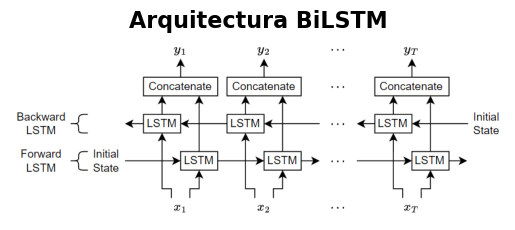

In [2]:
img = mpimg.imread('C:/Users/henry/Documents/jbook/project_NLP1/images/BiLSTM.png')
plt.imshow(img)
plt.axis('off') 
plt.title('Arquitectura BiLSTM', fontsize=16, fontweight='bold')
plt.show()

#### Cargue de datos

In [78]:
datapath = 'C:/Users/henry/Documents/jbook/project_NLP1/datos/'
data = pd.read_csv(datapath + 'to_models.csv')

In [53]:
train, test = train_test_split(data, test_size=0.20, random_state=42)

In [54]:
def tokenize(text):
    tokens = []
    if isinstance(text, str):  # Asegúrate de que el texto sea una cadena
        for sent in nltk.sent_tokenize(text):
            for word in nltk.word_tokenize(sent):
                if len(word) <= 0:
                    continue
                tokens.append(word.lower())  # Corregido "lowwer" a "lower"
    return tokens

train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize(r['message'] if isinstance(r['message'], str) else ""), tags=[r.label]), axis=1)
test_tagged  = test.apply(lambda r: TaggedDocument(words=tokenize(r['message'] if isinstance(r['message'], str) else ""), tags=[r.label]), axis=1)


In [55]:
# Replace NaN values in the 'message' column with an empty string
data['message'] = data['message'].fillna('')

# Process the 'message' column to split words and count unique words
all_words = list(itertools.chain.from_iterable(data['message'].apply(lambda x: x.split())))
word_counts = Counter(all_words)
print(f"Total de palabras únicas: {len(word_counts)}")

Total de palabras únicas: 27217


In [56]:
max_features = 6000
data['message'].apply(lambda x: len(x.split())).describe()

count    10998.000000
mean        10.717494
std         12.533056
min          0.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        243.000000
Name: message, dtype: float64

In [57]:
MAX_SEQUENCE_LENGTH = 100

In [58]:
max_features = 5000  
embedding_dim = 50 

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[$$^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['message'].values)
X = tokenizer.texts_to_sequences(data['message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Found %s unique tokens.' % len(X))
print('Shape of data tensor:', X.shape)

Found 10998 unique tokens.
Shape of data tensor: (10998, 100)


In [59]:
train_tagged.values

array([TaggedDocument(words=['hahahaha', 'mogambo', 'khush'], tags=['Positivo']),
       TaggedDocument(words=['inquiry', 'chahye'], tags=['Positivo']),
       TaggedDocument(words=['wese', 'twitter', 'nazar', 'twitter', 'ronaq', 'dobala'], tags=['Positivo']),
       ...,
       TaggedDocument(words=['baron', 'hsla', 'afzai', 'hee', 'hamarey', 'hey'], tags=['Positivo']),
       TaggedDocument(words=['fia', 'dar', 'dr', 'asim', 'case', 'zidha', 'big', 'musharf', 'article', 'afsos', 'sahaft'], tags=['Negativo']),
       TaggedDocument(words=['adeel', 'boss', 'pyar', 'bhara'], tags=['Positivo'])],
      dtype=object)

In [60]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=12, alpha=0.065, min_alpha=0.065)

In [61]:
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 8798/8798 [00:00<?, ?it/s]


In [62]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 8798/8798 [00:00<00:00, 546510.57it/s]


CPU times: total: 35.2 s
Wall time: 38.1 s


In [63]:
print(d2v_model)

Doc2Vec<dm/m,d20,n5,w8,s0.001,t12>


In [64]:
num_words = len(d2v_model.wv.key_to_index)
print(num_words)

23871


In [65]:
words = d2v_model.wv.index_to_key
print(words[-10:])

['noqsan', 'lapait', 'zarye', 'westren', 'chatpati', 'daffinetly', 'boldiya', 'paktoon', 'nalaqe', 'sahaft']


A continuación se entrenan los embeddings del modelo para poder realizar la hiperparametrización.

In [66]:
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index)+ 1, 20))

In [67]:
for i in range(len(d2v_model.dv)):
    vec = d2v_model.dv[i]
    if vec is not None and len(vec) <= 1000:
        print(i)
        print(d2v_model.dv)
        embedding_matrix[i] = vec
        print(vec)

0
KeyedVectors<vector_size=20, 2 keys>
[-0.44807473 -2.704889   -7.7218657   2.997391   -2.0672789  -0.2319688
 -5.9688478   0.21713771 -8.400917    1.0867647   0.4456104   1.5249355
 -1.6133018   2.098417   -1.6664804  -7.8435726  -1.793396   -0.18616118
 -6.767064   -1.1986817 ]
1
KeyedVectors<vector_size=20, 2 keys>
[-2.934743    2.3148718   0.97134763  1.0171957   4.531644   -3.0377693
 -3.4410603  -4.5871058   4.575576   -3.4638448   4.573713    3.2726018
 -2.846714   -6.324047   -1.5647299   3.6651394   0.3148525   1.124608
 -0.54153943 -1.2454855 ]


In [68]:
d2v_model.wv.most_similar(positive=['pakistan'], topn=10)

[('donoon', 0.7961616516113281),
 ('kamzarf', 0.7950690388679504),
 ('sauda', 0.7943793535232544),
 ('bhaagne', 0.7756441235542297),
 ('tarki', 0.7728510499000549),
 ('kitnein', 0.7670255303382874),
 ('aajay', 0.7602293491363525),
 ('kasai', 0.7599718570709229),
 ('gadaar', 0.7580880522727966),
 ('bhater', 0.7569281458854675)]

### Parámetros del modelo

En la ejecución de la arquitectura de la red BiLSTM se implementan parámetros que ajustan las predicciones. A continuación se muestra una lista y descripción de los mismos:

In [69]:
"""
param_grid_lstm = {
    'lstm_units': [64, 128, 256],
    'num_lstm_layers': [1, 2, 3],
    'dropout_rate': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.005, 0.01],
    'batch_size': [32, 64, 128],
    'sequence_length': [50, 100, 200],
    'epochs': [20, 50, 100],
    'embedding_dim': [100, 200, 300]
}
"""

"\nparam_grid_lstm = {\n    'lstm_units': [64, 128, 256],\n    'num_lstm_layers': [1, 2, 3],\n    'dropout_rate': [0.2, 0.3, 0.5],\n    'learning_rate': [0.001, 0.005, 0.01],\n    'batch_size': [32, 64, 128],\n    'sequence_length': [50, 100, 200],\n    'epochs': [20, 50, 100],\n    'embedding_dim': [100, 200, 300]\n}\n"

```{admonition} **lstm_units**
Representa el número de unidades (neuronas) en la capa LSTM. Controla la capacidad del modelo para aprender patrones y memorizar dependencias en los datos secuenciales.

- Más unidades: El modelo tendrá más capacidad para aprender patrones complejos, pero puede volverse más lento y propenso a sobreajuste.
- Menos Unidades: El modelo puede ser más rápido, pero tendrá menor capacidad para aprender patrones complejos.
```

Valores posibles: ``[64, 128, 256]``

``**num_lstm_layers**`` : Indica el número de capas LSTM apiladas en la red. y tiene como valores en esta hiperparametrización = ``[1, 2, 3]``

```{admonition} **Droptout_rate**
Es la fracción de nodos que se desconectan aleatoriamente durante el entrenamiento para evitar el sobreajuste.

- Valores posibles: ``[0.2, 0.3, 0.5]``
```

**Learning_Rate**: La tasa de aprendizaje controla la magnitud de las actualizaciones en los pesos del modelo durante el entrenamiento. Entre mayor sea, el modelo puede aprender más rápido, pero corre el riesgo de no converger o saltarse el mínimo óptimo. Mientas que si es más baja, el modelo se entrenaría más lentamente y tiene menos probabilidades de saltarse mínimos locales, pero podría quedarse atrapado en un mínimo subóptimo si es demasiado baja. 

- Valores posibles: ``[0.001, 0.005, 0.01]``

- **``Batch_size``** = El tamaño del lote de datos que se usa para cada paso de entrenamiento. Tamaños pequeños de batch ayudan a una mejor generalización, pero mayor tiempo de entrenamiento y más ruido en la actualización de los pesos, mientras que tamaños grandes de batch generan menos ruido, pero puede ser más propenso al sobreajuste y podría no generalizar tan bien. Valores posibles = ``[32, 64, 128]``

```{admonition} Sequence_length
La longitud máxima de las secuencias de texto que se alimentan a la red. Los textos más largos se truncarán y los más cortos se rellenarán con ceros. Si se elige una longitud de secuencia más larga, se pierde más información de los mensajes largos, pero los mensajes cortos se mantienen completos.

- Valores posibles = [50, 100, 200]
```

```{admonition} Embedding_dim
La dimensión de los vectores de palabras en la capa de embeddings. Define el tamaño de los vectores que representan las palabras. Vectores pequeños tienen menos capacidad para capturar significados semánticos ricos, pero más rápido de entrenar. y vectores grandes tienen más capacidad para capturar semántica rica, pero más costoso computacionalmente.

- valores posibles = [100, 200, 300]

```

## Hiperparametrización para BiLSTM

In [70]:
print(train['label'].isnull().sum())

le = LabelEncoder()
y = le.fit_transform(train['label'])

#dImensiones
print(X.shape)  
print(len(y)) 

0
(10998, 100)
8798


In [71]:
print(train.shape)
print(test.shape)


(8798, 3)
(2200, 3)


**Parámetros a optimizar**

In [72]:
param_grid_lstm = {
    'lstm_units': [64, 128, 256],
    'num_lstm_layers': [1, 2, 3],
    'dropout_rate': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.005, 0.01],
    'batch_size': [32, 64, 128],
    'sequence_length': [50, 100, 200],
    'epochs': [20, 50],
    'embedding_dim': [100, 200, 300]
}

In [73]:
grid = ParameterGrid(param_grid_lstm)

In [ ]:
# Combinaciones
for params in grid:
    sequence_length = params['sequence_length'] #Del conjunto de parámetros
    # Replace NaN values in the 'message' column with an empty string
    train['message'] = train['message'].fillna('')
    test['message'] = test['message'].fillna('')

    X_train = tokenizer.texts_to_sequences(train['message'].values)
    X_train = pad_sequences(X_train, maxlen=sequence_length)

    # test
    X_test = tokenizer.texts_to_sequences(test['message'].values)
    X_test = pad_sequences(X_test, maxlen=sequence_length)
    le = LabelEncoder()
    y_train = le.fit_transform(train['label'])  
    y_test = le.transform(test['label'])  

    #modelo LSTM
    model = Sequential()
    #Capa de embedding
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=sequence_length))
    # Capa LSTM
    model.add(Bidirectional(LSTM(units=params['lstm_units'], return_sequences=False)))
    model.add(Dropout(params['dropout_rate']))
    #Capa densa para la salida
    model.add(Dense(1, activation='sigmoid'))  
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=params['learning_rate']), metrics=['accuracy'])
    print(f"Entrenando modelo con parámetros: {params}")
    model.summary()

    # modelo
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2)
    score = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {score[0]}")
    print(f"Test Accuracy: {score[1]}")



Entrenando modelo con parámetros: {'batch_size': 32, 'dropout_rate': 0.2, 'embedding_dim': 100, 'epochs': 20, 'learning_rate': 0.001, 'lstm_units': 64, 'num_lstm_layers': 1, 'sequence_length': 50}
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 50)            1360900   
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              58880     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,419,909
Trainable params: 1,419,909
Non

Se escogen los mejores parámetros

Con un ``Test Accuracy de 0.7514 (75.14%)``, se escogen:
- lstm_units:	64
- num_lstm_layers:	1
- dropout_rate:	0.3
- learning_rate:	0.001
- batch_size:	32
- sequence_length:	200
- epochs:	20
- embedding_dim:	100


## Modelo final con los mejores parámetros

In [35]:
lstm_units = 32
num_lstm_layers = 1
dropout_rate = 0.3
learning_rate = 0.001
batch_size = 32
sequence_length = 150
epochs = 20
embedding_dim = 150

In [36]:
train, test = train_test_split(data, test_size=0.20, random_state=42)

# Tokenización
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(train['message'].values)
X_train = tokenizer.texts_to_sequences(train['message'].values)
X_train = pad_sequences(X_train, maxlen=sequence_length)
X_test = tokenizer.texts_to_sequences(test['message'].values)
X_test = pad_sequences(X_test, maxlen=sequence_length)

In [37]:
# Codificación de etiquetas
le = LabelEncoder()
y_train = le.fit_transform(train['label'])
y_test = le.transform(test['label'])

In [38]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=embedding_dim,
                    input_length=sequence_length))
model.add(Bidirectional(LSTM(units=lstm_units)))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

In [39]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 150)          3580650   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               46848     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,627,563
Trainable params: 3,627,563
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
220/220 [==============================] - 11s 34ms/step - loss: 0.5898 - accuracy: 0.6750 - val_loss: 0.5189 - val_accuracy: 0.7290
Epoch 2/20
220/220 [==============================] - 7s 33ms/step - loss: 0.3691 - accuracy: 0.8400 - val_loss: 0.5308 - val_accuracy: 0.7472
Epoch 3/20
220/220 [==============================] - 7s 30ms/step - loss: 0.2735 - accuracy: 0.8893 - val_loss: 0.6206 - val_accuracy: 0.7523
Epoch 4/20
220/220 [==============================] - 6s 28ms/step - loss: 0.2025 - accuracy: 0.9213 - val_loss: 0.7073 - val_accuracy: 0.7437
Epoch 5/20
220/220 [==============================] - 6s 28ms/step - loss: 0.1471 - accuracy: 0.9471 - val_loss: 0.8297 - val_accuracy: 0.7420
Epoch 6/20
220/220 [==============================] - 6s 27ms/step - loss: 0.1150 - accuracy: 0.9574 - val_loss: 0.9423 - val_accuracy: 0.7420
Epoch 7/20
220/220 [==============================] - 6s 28ms/step - loss: 0.0965 - accuracy: 0.9641 - val_loss: 0.9748 - val_accuracy: 0.727

In [42]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'\nTest Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

69/69 [==============================] - 1s 14ms/step - loss: 1.6857 - accuracy: 0.7573

Test Loss: 1.6857
Test Accuracy: 0.7573


El modelo alcanzó una precisión final en el conjunto de entrenamiento cercana al 99%, mientras que en el conjunto de validación esta métrica se estabilizó en torno al 73%. Esta diferencia marcada evidencia una alta capacidad del modelo para aprender los patrones presentes en los datos con los que fue entrenado, pero una limitada habilidad para generalizar dicho conocimiento a nuevos ejemplos. Además, se observa una tendencia en la cual el error de validación no solo se mantiene alto, sino que empeora a medida que el entrenamiento avanza. Esto indica que el modelo continúa ajustándose a detalles específicos del entrenamiento que no son relevantes para la generalización, lo cual sugiere la presencia de sobreajuste.

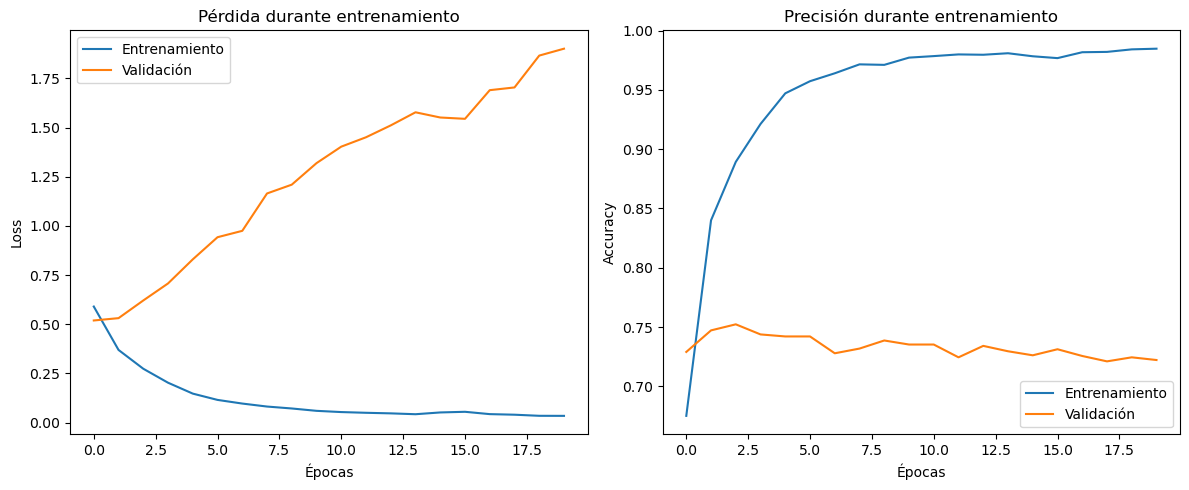

In [43]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Métricas de Predicción

El modelo entrenado alcanza una precisión global (accuracy) del 76%, lo que indica que aproximadamente tres de cada cuatro predicciones realizadas coinciden con la etiqueta real. Este valor, aunque no extremadamente alto, sí representa un desempeño aceptable considerando la naturaleza del problema y el tipo de datos utilizados. Más allá del valor general de precisión, es clave examinar las métricas específicas por clase para tener una comprensión más profunda del comportamiento del modelo.

In [44]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

69/69 [==============================] - 1s 13ms/step


El modelo alcanza una precisión global (accuracy) de 76%, lo que indica que clasifica correctamente tres de cada cuatro instancias. Este valor, aunque no sobresaliente, sí representa un desempeño competitivo para tareas de clasificación de texto como análisis de sentimiento, especialmente cuando se mantiene balance entre clases. Los valores de precision, recall y f1-score están distribuidos de forma relativamente equilibrada, tanto entre clases como en sus promedios.

1. Clase Negativo:

- Precision: 0.77 = el modelo es bastante certero cuando predice que un ejemplo es negativo.

- Recall: 0.72 = logra recuperar el 72% de todos los casos negativos reales.

- F1-score: 0.74 = equilibrio aceptable entre ambas métricas.

2. Clase Positivo:

- Precision: 0.75= ligeramente inferior, pero aún dentro de un rango óptimo.

- Recall: 0.79 = destaca por su capacidad de detección de casos positivos.

- F1-score: 0.77 = sólido, lo que indica consistencia en el rendimiento.

In [45]:
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))



 Reporte de clasificación:
              precision    recall  f1-score   support

    Negativo       0.77      0.72      0.74      1075
    Positivo       0.75      0.79      0.77      1125

    accuracy                           0.76      2200
   macro avg       0.76      0.76      0.76      2200
weighted avg       0.76      0.76      0.76      2200



In [46]:
auc = roc_auc_score(y_test, y_pred_probs)
print(f"\nAUC: {auc:.4f}")


AUC: 0.8049


```{admonition} Curva ROC y AUC
La curva ROC (Receiver Operating Characteristic) representa la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) a diferentes umbrales de decisión. El área bajo esta curva, conocida como AUC (Area Under the Curve), es una métrica robusta para evaluar el desempeño general de un modelo de clasificación binaria, especialmente en escenarios donde el balance entre clases puede influir en la precisión simple.
```

En este caso, el valor 0.8049 indica un desempeño sólidamente bueno, lo que significa que, ante dos ejemplos aleatorios —uno positivo y uno negativo— el modelo tiene un 80.49% de probabilidad de asignar una puntuación mayor al positivo. Este valor está por encima del umbral de 0.8, que suele marcar un punto de calidad en la mayoría de problemas de clasificación. Implica que el modelo no solo tiene un buen rendimiento en un único punto de corte (como cuando se evalúa con accuracy a 0.5), sino que se comporta bien en un rango amplio de umbrales.

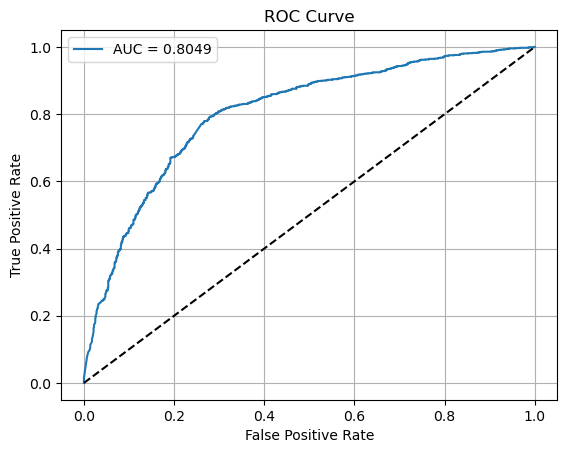

In [47]:
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

- 775 verdaderos negativos (TN): ejemplos negativos correctamente clasificados.

- 300 falsos positivos (FP): ejemplos negativos clasificados incorrectamente como positivos.

- 891 verdaderos positivos (TP): ejemplos positivos correctamente clasificados.

- 234 falsos negativos (FN): ejemplos positivos que fueron clasificados como negativos.



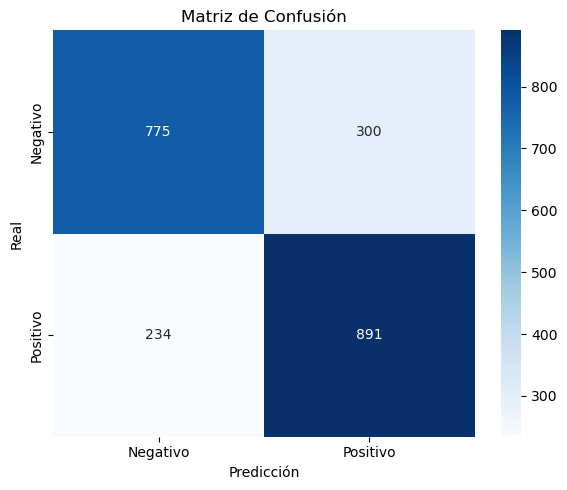

In [48]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()